# Decoding Cocaine Brainwave Connectivity   
do these plots by region with pre and post cocaine (like NAcc on top pre and NAcc on cocaine on bottom)?  Just for Beta and theta  but for all four regions on sperate graphs?

Currently: 2 subjects (mice), 2 recordings (1-2), 2 tasks (pre-cocaine, post-cocaine).   
Time per recording: 0-1799 seconds

In [13]:
print("[INFO] mounting google drive directory...\n[INFO] if prompted follow the link and copy and paste the token.")
from google.colab import drive
drive.mount('/content/drive')


[INFO] mounting google drive directory...
[INFO] if prompted follow the link and copy and paste the token.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
print("[INFO] installing nilearn for session...")
!pip install nilearn

[INFO] installing nilearn for session...


In [ ]:
# import packages 
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core import display as ICD
import pandas as pd
import glob, os
import seaborn as sns
import nilearn
from sklearn import svm
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# setting color dictionaries for maps

post_color_dict= {'PFC gamma': 'purple', 'VTA gamma':'violet', 'BLA gamma':'plum', 'NAc gamma':'mediumorchid',
             'PFC beta': 'dodgerblue', 'VTA beta':'lightskyblue', 'BLA beta':'turquoise', 
             'NAc beta':'deepskyblue', 'PFC theta': 'limegreen', 'VTA theta':'palegreen',
             'BLA theta': 'yellowgreen', 'NAc theta':'olive'}

pre_color_dict= {'PFC gamma': 'dimgray', 'VTA gamma':'gray', 'BLA gamma':'silver', 'NAc gamma':'lightgray',
             'PFC beta': 'red', 'VTA beta':'darkred', 'BLA beta':'indianred', 
             'NAc beta':'lightcoral', 'PFC theta': 'gold', 'VTA theta':'goldenrod',
             'BLA theta': 'orange', 'NAc theta':'yellow'}




## Data Preparation 

In [17]:
# load the data file into a data frame 

print('[INFO] loading the multisite brainwave connectivity data into a dataframe now...')
multisite_df = pd.read_csv('drive/My Drive/Projects/pilot_mouse_connectivity/cocaine_two_mice/Spectrogram_data/updated_data/multisite_averaged_data.csv')

multisite_df.head()

[INFO] loading the multisite brainwave connectivity data into a dataframe now...


,Unnamed: 0,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
0,0,-56.501194,-58.404691,-53.796707,-54.683450,-50.765295,-49.201600,-47.156084,-47.257051,-37.099407,-37.333310,-35.815629,-36.039001,31.250000,1,0,0.461047,post,1
1,1,-55.990462,-58.988152,-54.108313,-53.480236,-49.899241,-49.516848,-45.858436,-48.210181,-40.991329,-42.757552,-36.514741,-38.500080,-40.040267,1,1,0.482850,post,1
2,2,-56.533964,-56.703969,-53.713006,-53.388769,-47.988294,-47.911166,-45.839712,-44.819948,-36.329574,-36.786060,-34.261496,-38.705199,-46.110695,1,2,0.490247,post,1
3,3,-55.088293,-57.277582,-54.759970,-53.832872,-49.272411,-47.161322,-46.172072,-46.595272,-37.772853,-33.544189,-36.755222,-39.528779,-41.637959,1,3,0.485528,post,1
4,4,-56.064453,-56.391981,-54.370658,-54.151737,-48.075181,-44.963544,-47.350350,-44.067891,-41.780323,-37.090223,-37.366601,-36.990245,-39.613447,1,4,0.494177,post,1


In [18]:
# drop unneccesary first column
print('INFO] cleaning data...')

multisite_df.drop("Unnamed: 0", axis=1,inplace=True)
print(multisite_df.columns.values)
multisite_df.head()


INFO] cleaning data...
['PFC gamma' 'VTA gamma' 'BLA gamma' 'NAc gamma' 'PFC beta' 'VTA beta'
 'BLA beta' 'NAc beta' 'PFC theta' 'VTA theta' 'BLA theta' 'NAc theta'
 'reference wires' 'mouse id' 'Time (s)' 'Speed (cm/s)' 'cocaine status'
 'recording']


,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
0,-56.501194,-58.404691,-53.796707,-54.683450,-50.765295,-49.201600,-47.156084,-47.257051,-37.099407,-37.333310,-35.815629,-36.039001,31.250000,1,0,0.461047,post,1
1,-55.990462,-58.988152,-54.108313,-53.480236,-49.899241,-49.516848,-45.858436,-48.210181,-40.991329,-42.757552,-36.514741,-38.500080,-40.040267,1,1,0.482850,post,1
2,-56.533964,-56.703969,-53.713006,-53.388769,-47.988294,-47.911166,-45.839712,-44.819948,-36.329574,-36.786060,-34.261496,-38.705199,-46.110695,1,2,0.490247,post,1
3,-55.088293,-57.277582,-54.759970,-53.832872,-49.272411,-47.161322,-46.172072,-46.595272,-37.772853,-33.544189,-36.755222,-39.528779,-41.637959,1,3,0.485528,post,1
4,-56.064453,-56.391981,-54.370658,-54.151737,-48.075181,-44.963544,-47.350350,-44.067891,-41.780323,-37.090223,-37.366601,-36.990245,-39.613447,1,4,0.494177,post,1


**Factorize categorical data**  

Here we create a new column "cocaine status num", that holds 0 if the true label is post cocaine, and 1 if the true label is pre cocaine. 

In [19]:
print('[INFO] factorizing target variable: cocaine status ...')
# turn cocaine category labels into numerics, 0: post and 1: pre
multisite_df['cocaine status num'] = pd.factorize(multisite_df['cocaine status'])[0]


[INFO] factorizing target variable: cocaine status ...


**Fill in NaN values with average**

In [20]:
print('[INFO] filling missing data with average ...')
multisite_df.fillna(multisite_df.mean(), inplace=True)
print('[INFO] view data ...')
multisite_df.tail()

[INFO] filling missing data with average ...
[INFO] view data ...


,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording,cocaine status num
14395,-57.945512,-60.610124,-54.832686,-54.930917,-53.453498,-54.694912,-48.215670,-54.100591,-45.402066,-43.293175,-41.552947,-44.923270,-56.379793,1,1795,1.145819,pre,2,1
14396,-57.283914,-61.857844,-53.046077,-56.369021,-53.506348,-52.885991,-44.472734,-46.909043,-36.616661,-43.950709,-33.409286,-38.811592,-56.379793,1,1796,0.167269,pre,2,1
14397,-57.621165,-62.037227,-54.470172,-56.285570,-50.645157,-48.306280,-46.802928,-46.783425,-46.357364,-41.330419,-36.800070,-37.888468,-56.379793,1,1797,0.155295,pre,2,1
14398,-59.532244,-61.890011,-54.634515,-54.805142,-51.794797,-54.021217,-47.390373,-51.180051,-48.041564,-42.124833,-35.664824,-40.147725,-56.379793,1,1798,0.004777,pre,2,1
14399,-58.429392,-62.086589,-54.455730,-56.122061,-47.567010,-49.108323,-46.107437,-52.037337,-41.694312,-42.653839,-33.130993,-40.041810,-56.379793,1,1799,0.000000,pre,2,1


**Normalize data**  
Here the brainwave data is being scaled. 

In [21]:
print('[INFO] scaling brainwave data down ...')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma',
       'PFC beta', 'VTA beta', 'BLA beta', 'NAc beta', 'PFC theta',
       'VTA theta', 'BLA theta', 'NAc theta', 'reference wires']] = scaler.fit_transform(multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma',
                                                                                                       'PFC beta', 'VTA beta', 'BLA beta', 'NAc beta', 'PFC theta',
                                                                                                       'VTA theta', 'BLA theta', 'NAc theta', 'reference wires']])
       
print('[INFO] Scaled data:')
multisite_df.tail()

[INFO] scaling brainwave data down ...
[INFO] Scaled data:


,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording,cocaine status num
14395,0.160803,0.098663,0.379112,0.435232,0.116256,0.096596,0.365786,0.217770,0.279710,0.291921,0.411115,0.285573,0.274108,1,1795,1.145819,pre,2,1
14396,0.181986,0.068729,0.430632,0.385932,0.114759,0.148119,0.458901,0.440185,0.478738,0.274591,0.601804,0.449501,0.274108,1,1796,0.167269,pre,2,1
14397,0.171188,0.064426,0.389566,0.388793,0.195808,0.278560,0.400931,0.444070,0.258068,0.343653,0.522407,0.474261,0.274108,1,1797,0.155295,pre,2,1
14398,0.109998,0.067958,0.384827,0.439544,0.163242,0.115785,0.386317,0.308095,0.219913,0.322715,0.548989,0.413663,0.274108,1,1798,0.004777,pre,2,1
14399,0.145310,0.063242,0.389982,0.394398,0.283002,0.255716,0.418233,0.281581,0.363707,0.308772,0.608321,0.416504,0.274108,1,1799,0.000000,pre,2,1


Create a dataframe that holds the regions averaged across waves

In [ ]:
region_avg_df=pd.DataFrame()

region_avg_df['NAc'] =  multisite_df.filter(regex=("NAc*")).mean(axis=1)
region_avg_df['PFC'] =  multisite_df.filter(regex=("PFC*")).mean(axis=1)
region_avg_df['VTA'] =  multisite_df.filter(regex=("VTA*")).mean(axis=1)
region_avg_df['BLA'] =  multisite_df.filter(regex=("BLA*")).mean(axis=1)
region_avg_df['reference wires'] = multisite_df['reference wires']
region_avg_df['mouse id'] = multisite_df['mouse id']
region_avg_df['Time (s)'] = multisite_df['Time (s)']
region_avg_df['Speed (cm/s)'] = multisite_df['Speed (cm/s)']
region_avg_df['cocaine status'] = multisite_df['cocaine status']
region_avg_df['recording'] = multisite_df['recording'] 

In [31]:
region_avg_df.tail()

,NAc,PFC,VTA,BLA,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
14395,0.312858,0.185590,0.162393,0.385338,0.274108,1,1795,1.145819,pre,2
14396,0.425206,0.258495,0.163813,0.497112,0.274108,1,1796,0.167269,pre,2
14397,0.435708,0.208355,0.228880,0.437635,0.274108,1,1797,0.155295,pre,2
14398,0.387100,0.164384,0.168819,0.440044,0.274108,1,1798,0.004777,pre,2
14399,0.364161,0.264006,0.209243,0.472179,0.274108,1,1799,0.000000,pre,2


In [ ]:
print('[INFO] plotting gamma waves for single mouse, pre and post...')
plt.figure(figsize=(10,5))


**View quick statistics of our cleaned dataframe.**

In [32]:
print('[INFO] dataframe description ...')
multisite_df.describe()

[INFO] dataframe description ...


,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),recording,cocaine status num
count,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000
mean,0.261145,0.188965,0.346571,0.405485,0.266216,0.258749,0.374048,0.392750,0.441893,0.422940,0.483505,0.450498,0.274108,1.500000,899.500000,6.688596,1.500000,0.500000
std,0.066228,0.056437,0.135918,0.120160,0.083588,0.082423,0.135611,0.112018,0.093361,0.098397,0.143820,0.119995,0.106795,0.500017,519.633205,7.822245,0.500017,0.500017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,0.210674,0.154091,0.275312,0.363726,0.204282,0.200829,0.293779,0.348723,0.383067,0.355873,0.395438,0.388330,0.274108,1.000000,449.750000,1.164028,1.000000,0.000000
50%,0.269784,0.181783,0.405947,0.440182,0.269026,0.244253,0.423005,0.413049,0.440549,0.408246,0.532329,0.470095,0.274108,1.500000,899.500000,3.521444,1.500000,0.500000
75%,0.306523,0.222549,0.440970,0.488397,0.319643,0.304513,0.469079,0.466032,0.502115,0.481467,0.584448,0.526519,0.352545,2.000000,1349.250000,9.661078,2.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1799.000000,46.229302,2.000000,1.000000


**Decoding Helper Functions**

In [ ]:
## data prep helper function
def dataSplit(df, x_target_columns, y_target_columns):
  # prepare data for decoding

  # pull out target data with columns  
  X=df[x_target_columns].to_numpy()
  y=multisite_df[y_target_columns]

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

  return X_train, X_test, y_train, y_test;

## classifier helper function 
def svmModelBuilder(X_train,X_test,y_train, y_test, kernel='linear'):
  print("[INFO] building %s SVM classifier"%kernel)

  # build, fit and predict model
  clf = svm.SVC()
  clf.fit(X_train, y_train.values.ravel())
  print("[INFO] fit model for beta.")
  y_pred=clf.predict(X_test)
  print("[INFO] predicted model for beta.")

  # view metrics data
  print("\n[INFO] Model Metrics: \n")
  print(confusion_matrix(y_test,y_pred))
  print(classification_report(y_test,y_pred))

  return clf, y_pred;


## nested CV helper function
def nestedCVBuilder(clf, X, y, k_range=[50, 150, 300,500, 1000, 3000, 5000]):
  # build grid pipeline and run cross validation
  grid = GridSearchCV(clf, param_grid={'C': k_range})
  print("[INFO] built grid pipeline,running nested cv...")
  nested_cv_scores = cross_val_score(grid, X, y.values.ravel(), cv=5)
  print("[INFO completed nested cross validation.")
  print("Nested CV score: %.4f" % np.mean(nested_cv_scores * 100))

  return grid, nested_cv_scores;

# plot post and pre plots
def plotBrainwavesStatus(keyword=" "):
  plt.figure(figsize=(15,10))
  fig, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
  fig.subplots_adjust(hspace=.4)
  ax1.set_title('%s pre-cocaine status'%keyword, fontsize=20)
  ax1.plot(multisite_df.loc[3600:5399, 'Time (s)'], multisite_df.loc[3600:5399, wave], label=wave+": pre",color='royalblue')
  ax2.set_title('%s post-cocaine status'%keyword, fontsize=20)
  ax2.plot(multisite_df.loc[0:1799, wave], label=wave+": post",color=post_color_dict[wave])


def plotBrainWaves(precolor, postcolor, keyword=" "):
  plt.figure(figsize=(10,5))

  for wave in pre_color_dict:
        if keyword in wave:
          plt.plot(multisite_df.loc[0:1799, wave], label=wave+": post",color=precolor)
          plt.plot(multisite_df.loc[3600:5399, 'Time (s)'], multisite_df.loc[3600:5399, wave], label=wave+": pre",color=postcolor)

          plt.title('Time Series Network, Mouse ID #1, recording 1, %s'%keyword)
          plt.xlabel('Time (s)')
          plt.ylabel('Wave Signal')
          plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
          plt.tight_layout()

## Decoding Gamma 
Input X is the gamma brainwave data: `multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma']]`,  
target variable y is the `multisite_df['cocaine status num']`

The numerical cocaine status translates as follows:  { 0: post, 1: pre }


**Quick Plotting brainwave signals**

Plot individual regions-

[INFO] plotting regions...


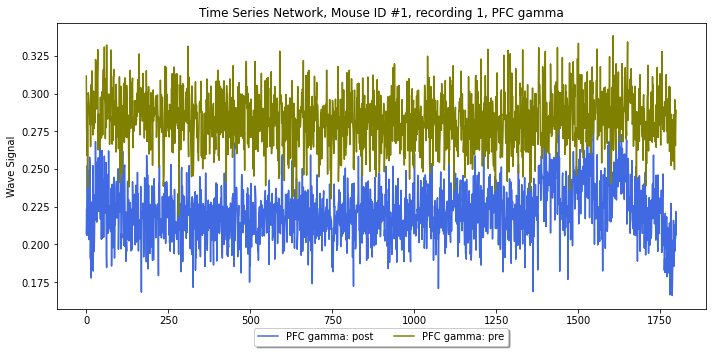

In [106]:
print("[INFO] plotting regions...")
plotBrainWaves('royalblue', 'olive',keyword="PFC gamma")


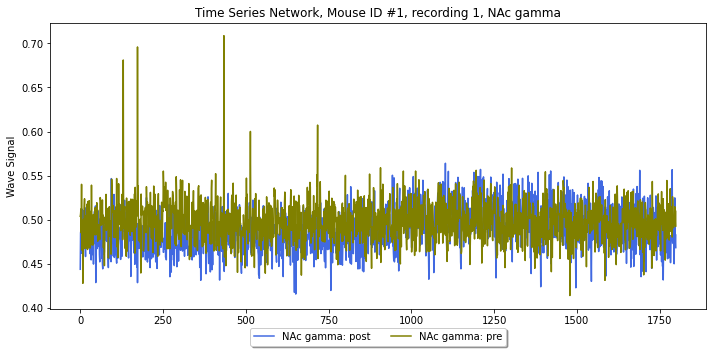

In [107]:
plotBrainWaves('royalblue', 'olive',keyword="NAc gamma")

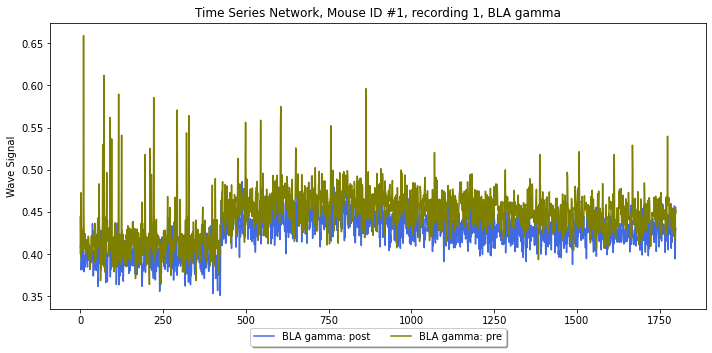

In [108]:
plotBrainWaves('royalblue', 'olive',keyword="BLA gamma")


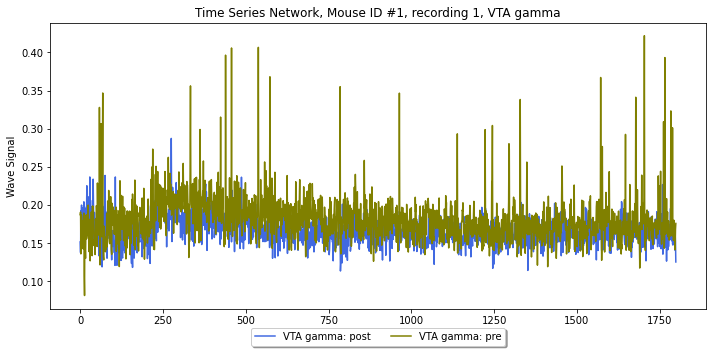

In [109]:
plotBrainWaves('royalblue', 'olive',keyword="VTA gamma")



[INFO] plotting pair plot of gamma waves:



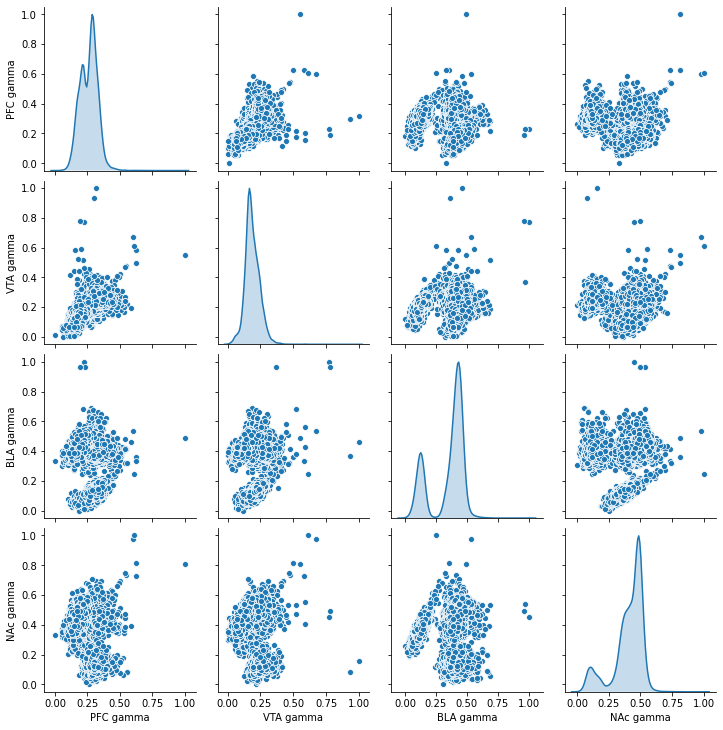

In [73]:
print("\n\n[INFO] plotting pair plot of gamma waves:\n")
sns.pairplot(multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma']],diag_kind="kde")


**Prepare input data**

**Setup input X and target y**

In [ ]:
# prepare the input data 
print('[INFO] preparing data for decoding gamma...')

# set X input array, 
# pull out the gamma columns from our dataframe and turn into numpy array
X=multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma']].to_numpy()
print("X shape: ",X.shape)

# set y target variable 
y=multisite_df['cocaine status num']
print("y shape: ", y.shape)

[INFO] preparing data for decoding gamma...
X shape:  (14400, 4)
y shape:  (14400,)


**Split datasets**

Training, testing and validation.

In [ ]:
print("[INFO] splitting training dataset")


X_train, X_validate, y_train, y_validate = train_test_split(X, y, random_state=0, test_size = 0.20)

X_train.shape, X_validate.shape, y_train.shape, y_validate.shape

[INFO] splitting training dataset


((11520, 4), (2880, 4), (11520,), (2880,))

**Create and fit the linear SVM classifier model**

In [ ]:
print("[INFO] creating the svm linear model...")
# creater classifier model, svm
gamma_svm = svm.SVC(kernel='linear')
gamma_svm

[INFO] creating the svm linear model...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# fit model with training data
gamma_svm.fit(X_train, y_train)
print("[INFO] fit model.")
# predict on validation data
gamma_y_pred=gamma_svm.predict(X_validate)
print("[INFO] predicted model.")


[INFO] fit model.
[INFO] predicted model.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("[INFO] view metrics...")

print(confusion_matrix(y_validate,gma_y_pred))
print(classification_report(y_validate,gma_y_pred))

[INFO] view metrics...
[[1016  413]
 [ 629  822]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1429
           1       0.67      0.57      0.61      1451

    accuracy                           0.64      2880
   macro avg       0.64      0.64      0.64      2880
weighted avg       0.64      0.64      0.64      2880



In [ ]:
print("[INFO] setting up nested cross validation pipeline...")

# set up nested CV pipeline with grid 
from sklearn.model_selection import GridSearchCV, cross_val_score 
k_range =  [50, 150, 300,500, 1000, 3000, 5000]
gamma_grid = GridSearchCV(gamma_svm, param_grid={'C': k_range}, scoring='accuracy')
gamma_nested_cv_scores = cross_val_score(gamma_grid, X_train, y_train, cv=5)

print("[INFO] Finished CV.")
print("Nested CV score: %.4f" % np.mean(gamma_nested_cv_scores*100))


[INFO] setting up nested cross validation pipeline...
[INFO] Finished CV.
Nested CV score: 64.0712


In [ ]:
gamma_svm.coef_

array([[  8.55999732, -17.80293729,  -0.17427279,  -2.99872527]])

## Decoding Beta

[INFO] plotting regions for beta...


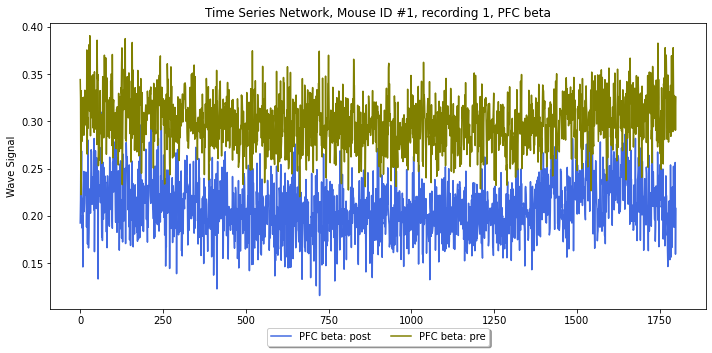

In [110]:
print("[INFO] plotting regions for beta...")
plotBrainWaves('royalblue', 'olive',keyword="PFC beta")


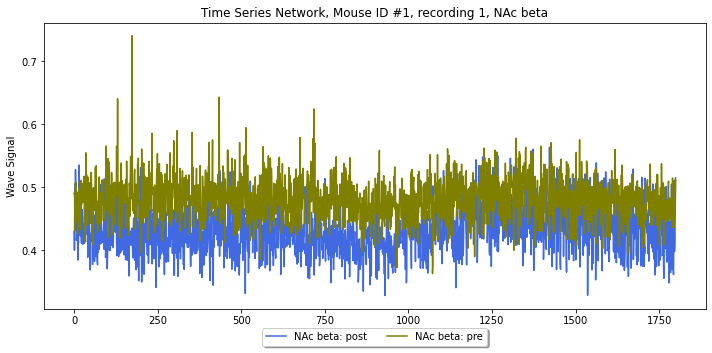

In [111]:
plotBrainWaves('royalblue', 'olive',keyword="NAc beta")


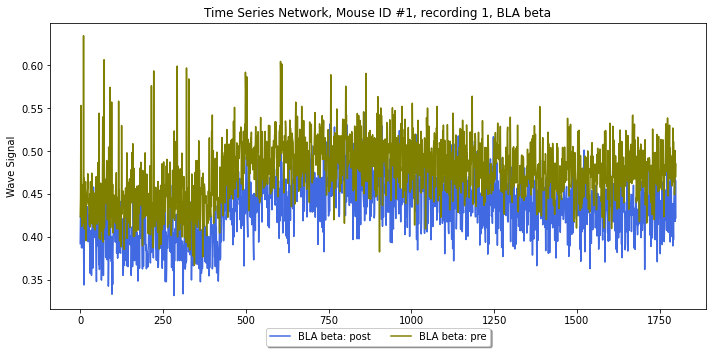

In [112]:
plotBrainWaves('royalblue', 'olive',keyword="BLA beta")


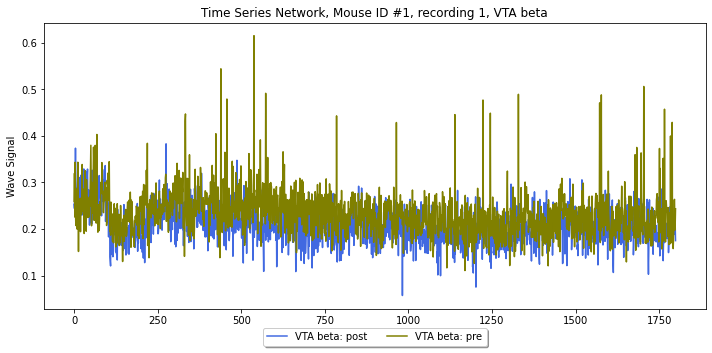

In [113]:
plotBrainWaves('royalblue', 'olive',keyword="VTA beta")


In [ ]:
# prepare data for decoding
# pull out beta columns  
X=multisite_df[['PFC beta', 'VTA beta', 'BLA beta', 'NAc beta']].to_numpy()

In [ ]:
y=multisite_df['cocaine status num']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
beta_svm = svm.SVC()
beta_svm.fit(X_train, y_train)
print("[INFO] fit model for beta.")
y_pred=beta_svm.predict(X_test)
print("[INFO] predicted model for beta.")


[INFO] fit model for beta.
[INFO] predicted model for beta.


In [ ]:
print("[INFO] running nested cross validation on beta waves...")

k_range = [10, 15, 30, 50, 150, 300, 500, 1000, 1500, 3000, 5000]
beta_grid = GridSearchCV(beta_svm, param_grid={'C': k_range}, scoring='accuracy')
beta_nested_cv_scores = cross_val_score(beta_grid, X_train, y_train, cv=5)
print("[INFO completed nested cross validation.")
print("Nested CV score: %.4f" % np.mean(beta_nested_cv_scores*100))


[INFO] running nested cross validation on beta waves...
[INFO completed nested cross validation.
Nested CV score: 77.6481


## Decoding Theta

[INFO] plotting regions...


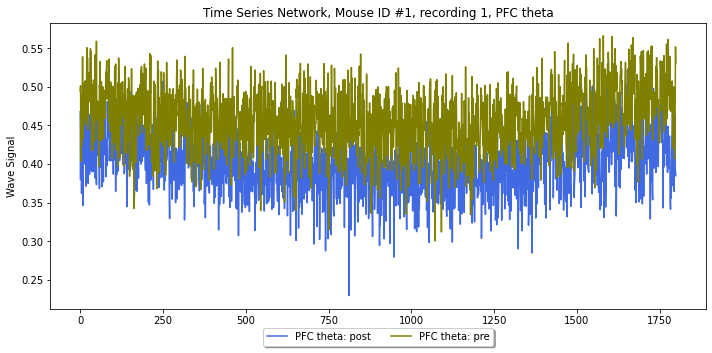

In [114]:
print("[INFO] plotting regions...")
plotBrainWaves('royalblue', 'olive',keyword="PFC theta")


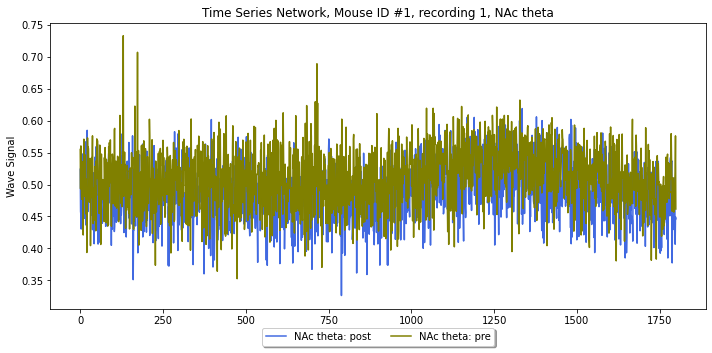

In [115]:
plotBrainWaves('royalblue', 'olive',keyword="NAc theta")

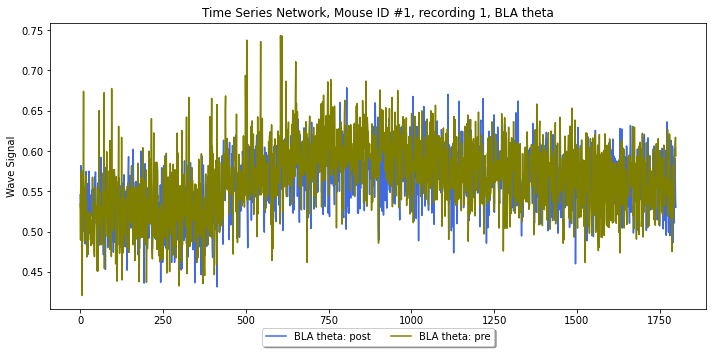

In [116]:
plotBrainWaves('royalblue', 'olive',keyword="BLA theta")

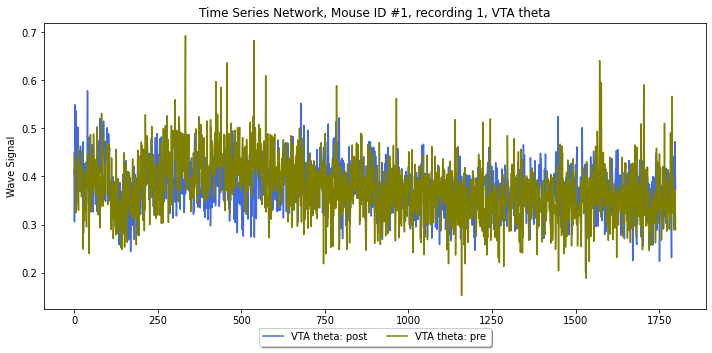

In [117]:
plotBrainWaves('royalblue', 'olive',keyword="VTA theta")

In [ ]:
# prepare data for decoding
# pull out theta columns  
X=multisite_df[['PFC theta', 'VTA theta', 'BLA theta', 'NAc theta',
                'reference wires', 'mouse id', 'Time (s)', 'Speed (cm/s)']].to_numpy()

In [ ]:
y=multisite_df['cocaine status num']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
print("[INFO] fitting classifier with theta waves...")

theta_svm = svm.SVC()
theta_svm.fit(X_train, y_train)
print("[INFO] fit model for theta.")
theta_y_pred=theta_svm.predict(X_test)
print("[INFO] predicted model for theta.")


[INFO] fitting classifier with theta waves...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print("[INFO] running cross validation on theta waves...")
theta_grid = GridSearchCV(theta_svm, param_grid={'C': k_range})
theta_nested_cv_scores = cross_val_score(theta_grid, X_train, y_train, cv=5)
print("[INFO completed nested cross validation.")
print("Nested CV score: %.4f" % np.mean(theta_nested_cv_scores * 100))


[INFO] running cross validation on theta waves...
[INFO completed nested cross validation.
Nested CV score: 85.1019


## Decoding with all regions and waves

In [ ]:
all_regions_df = multisite_df.loc[:, ['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma', 'PFC beta', 'VTA beta',
 'BLA beta', 'NAc beta', 'PFC theta', 'VTA theta', 'BLA theta', 'NAc theta', 'cocaine status num']]

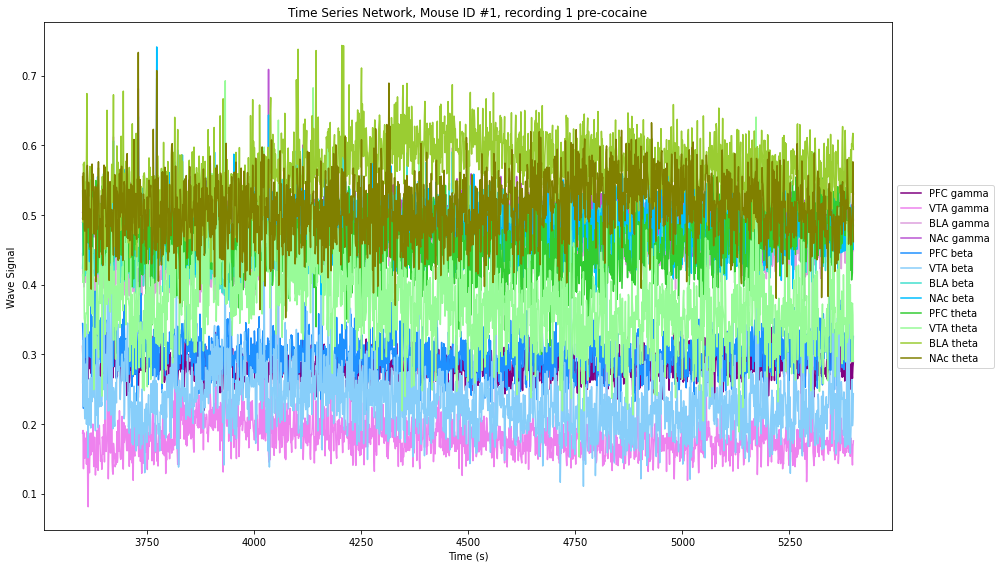

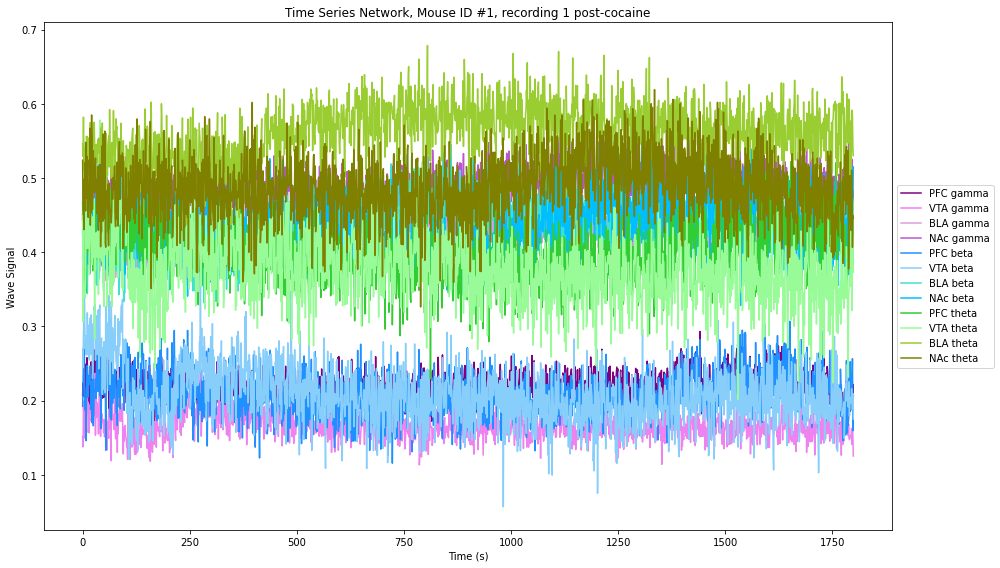

In [122]:
# full data decoding
plt.figure(figsize=(14,8))

for wave in pre_color_dict:
       plt.plot(multisite_df.loc[3600:5399, wave], label=wave,color=post_color_dict[wave])
 
plt.title('Time Series Network, Mouse ID #1, recording 1 pre-cocaine')
plt.xlabel('Time (s)')
plt.ylabel('Wave Signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()


plt.figure(figsize=(14,8))

for wave in post_color_dict:
       plt.plot(multisite_df.loc[0:1799, wave], label=wave,color=post_color_dict[wave])
 
plt.title('Time Series Network, Mouse ID #1, recording 1 post-cocaine')
plt.xlabel('Time (s)')
plt.ylabel('Wave Signal')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [ ]:
x_cols=['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma', 'PFC beta', 'VTA beta',
 'BLA beta', 'NAc beta', 'PFC theta', 'VTA theta', 'BLA theta', 'NAc theta']
y_cols=['cocaine status num']

In [ ]:
X_train, X_test, y_train, y_test=dataSplit(all_regions_df, x_cols, y_cols)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10800, 12), (3600, 12), (10800, 1), (3600, 1))

In [ ]:
clf, y_pred=svmModelBuilder(X_train,X_test,y_train, y_test)

[INFO] building linear SVM classifier
[INFO] fit model for beta.
[INFO] predicted model for beta.

[INFO] Model Metrics: 

[[1596  197]
 [ 359 1448]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1793
           1       0.88      0.80      0.84      1807

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



In [ ]:
grid, nested_cv_scores=nestedCVBuilder(clf,X_train, y_train)

[INFO] built grid pipeline,running nested cv...
[INFO completed nested cross validation.
Nested CV score: 85.9537


## Decoding by Regions


**PFC Region**

In [123]:
# region based decoding
pfc_region= multisite_df.filter(regex=("PFC*"))
pfc_region['cocaine status']= multisite_df['cocaine status']
pfc_region.head()

,PFC gamma,PFC beta,PFC theta,cocaine status
0,0.207048,0.192405,0.467802,post
1,0.223401,0.216938,0.379633,post
2,0.205999,0.271069,0.485242,post
3,0.252287,0.234694,0.452546,post
4,0.221032,0.268608,0.361758,post


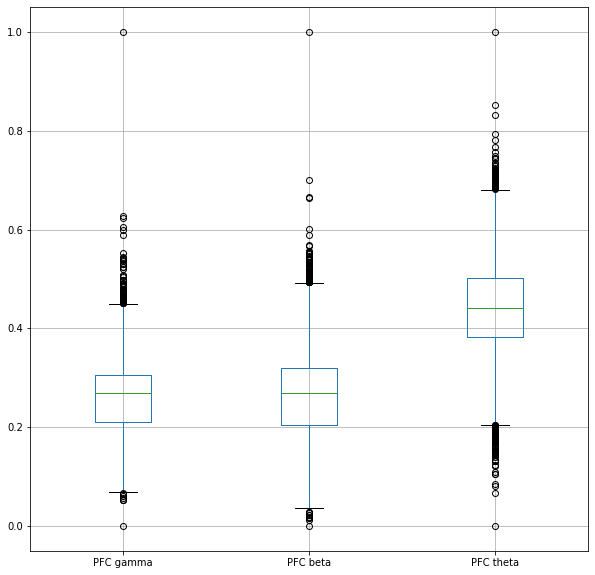

In [124]:
pfc_region.boxplot(figsize=(10,10))

In [ ]:
x_cols=['PFC gamma', 'PFC beta', 'PFC theta']
y_cols=['cocaine status']
pfc_region['cocaine status']= multisite_df['cocaine status num']
X_train, X_test, y_train, y_test=dataSplit(pfc_region, x_cols, y_cols)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10800, 3), (3600, 3), (10800, 1), (3600, 1))

In [ ]:
clf, y_pred=svmModelBuilder(X_train,X_test,y_train, y_test)

[INFO] building linear SVM classifier
[INFO] fit model for beta.
[INFO] predicted model for beta.

[INFO] Model Metrics: 

[[1372  421]
 [ 461 1346]]
              precision    recall  f1-score   support

        post       0.75      0.77      0.76      1793
         pre       0.76      0.74      0.75      1807

    accuracy                           0.76      3600
   macro avg       0.76      0.76      0.75      3600
weighted avg       0.76      0.76      0.75      3600



In [ ]:
grid, nested_cv_scores=nestedCVBuilder(clf,X_train, y_train)

[INFO] built grid pipeline,running nested cv...
[INFO completed nested cross validation.
Nested CV score: 74.9352


In [ ]:

vta_region= multisite_df.filter(regex=("VTA*"))
vta_region['cocaine status']= multisite_df.loc[:,'cocaine status']

In [ ]:

nac_region= multisite_df.filter(regex=("NAc*"))
nac_region['cocaine status']= multisite_df.loc[:,'cocaine status']


In [ ]:
bla_region= multisite_df.filter(regex=("BLA*"))
bla_region['cocaine status']= multisite_df.loc[:,'cocaine status']
